# QAOA for the MAX-CUT Problem 

In [5]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob,StatevectorEstimator
from qiskit.circuit.library import TwoLocal,EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# Drawing Graphs in Qiskit

Lets try to solve the below graph and see where we have to cut to solve the maxcut problem


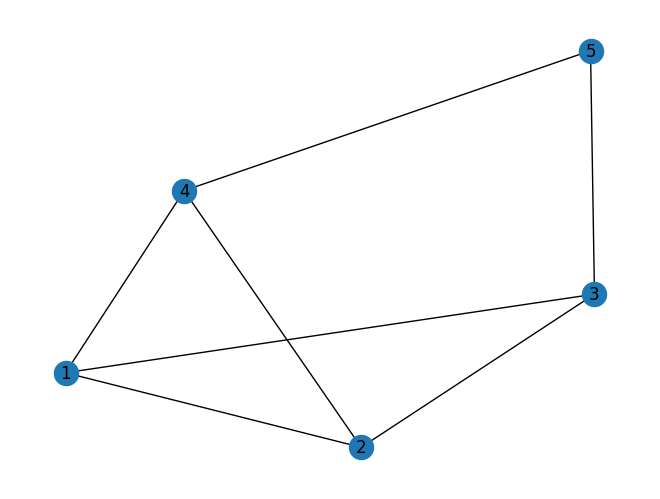

In [6]:
#importing networkx
import networkx as nx
#importing matplotlib.pyplot
import matplotlib.pyplot as plt


#Create a Graph
G = nx.Graph()
#add a node
G.add_node(1)
G.add_nodes_from ([2,3,4,5])
#add edges
G.add_edge(1,2)
e = (2,3)
G.add_edge(*e) # the * unpacks the tuple
G.add_edges_from([(1,2),(1,3),(4,5),(2,4),(1,4),(3,5)])
print("Lets try to solve the below graph and see where we have to cut to solve the maxcut problem")
nx.draw(G, with_labels =True)
plt.savefig("basicgraph2.png")

#  Lets build our Hamiltonian

In [7]:
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("IIZZI", 1),("IZIZI", 1),("ZIZII", 1),("ZZIII", 1)])


# Let us use the QAOA Ansatz for our algorithm

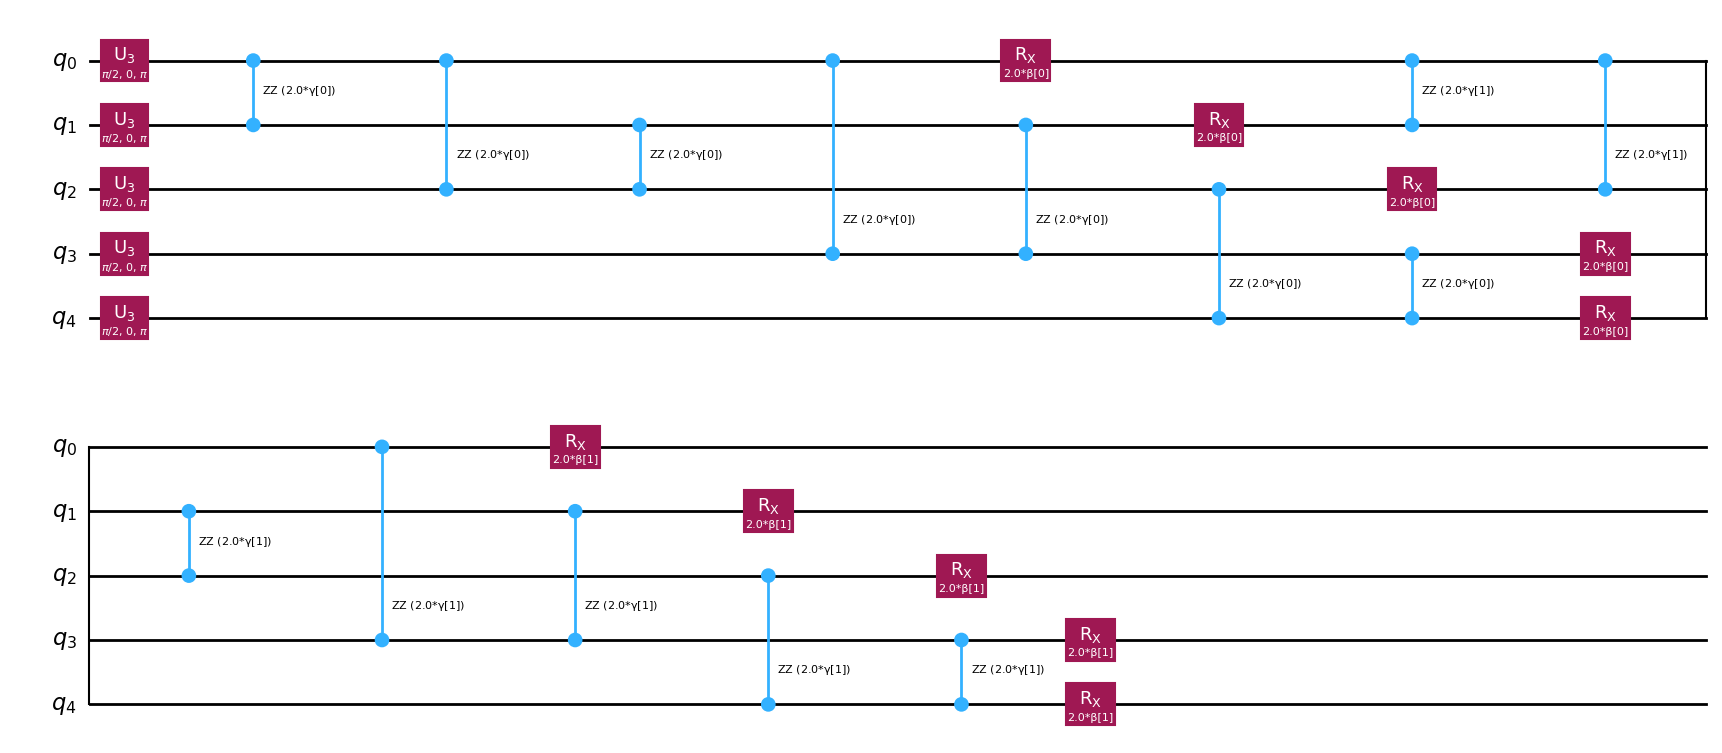

In [8]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

# Transpiling the Circuit

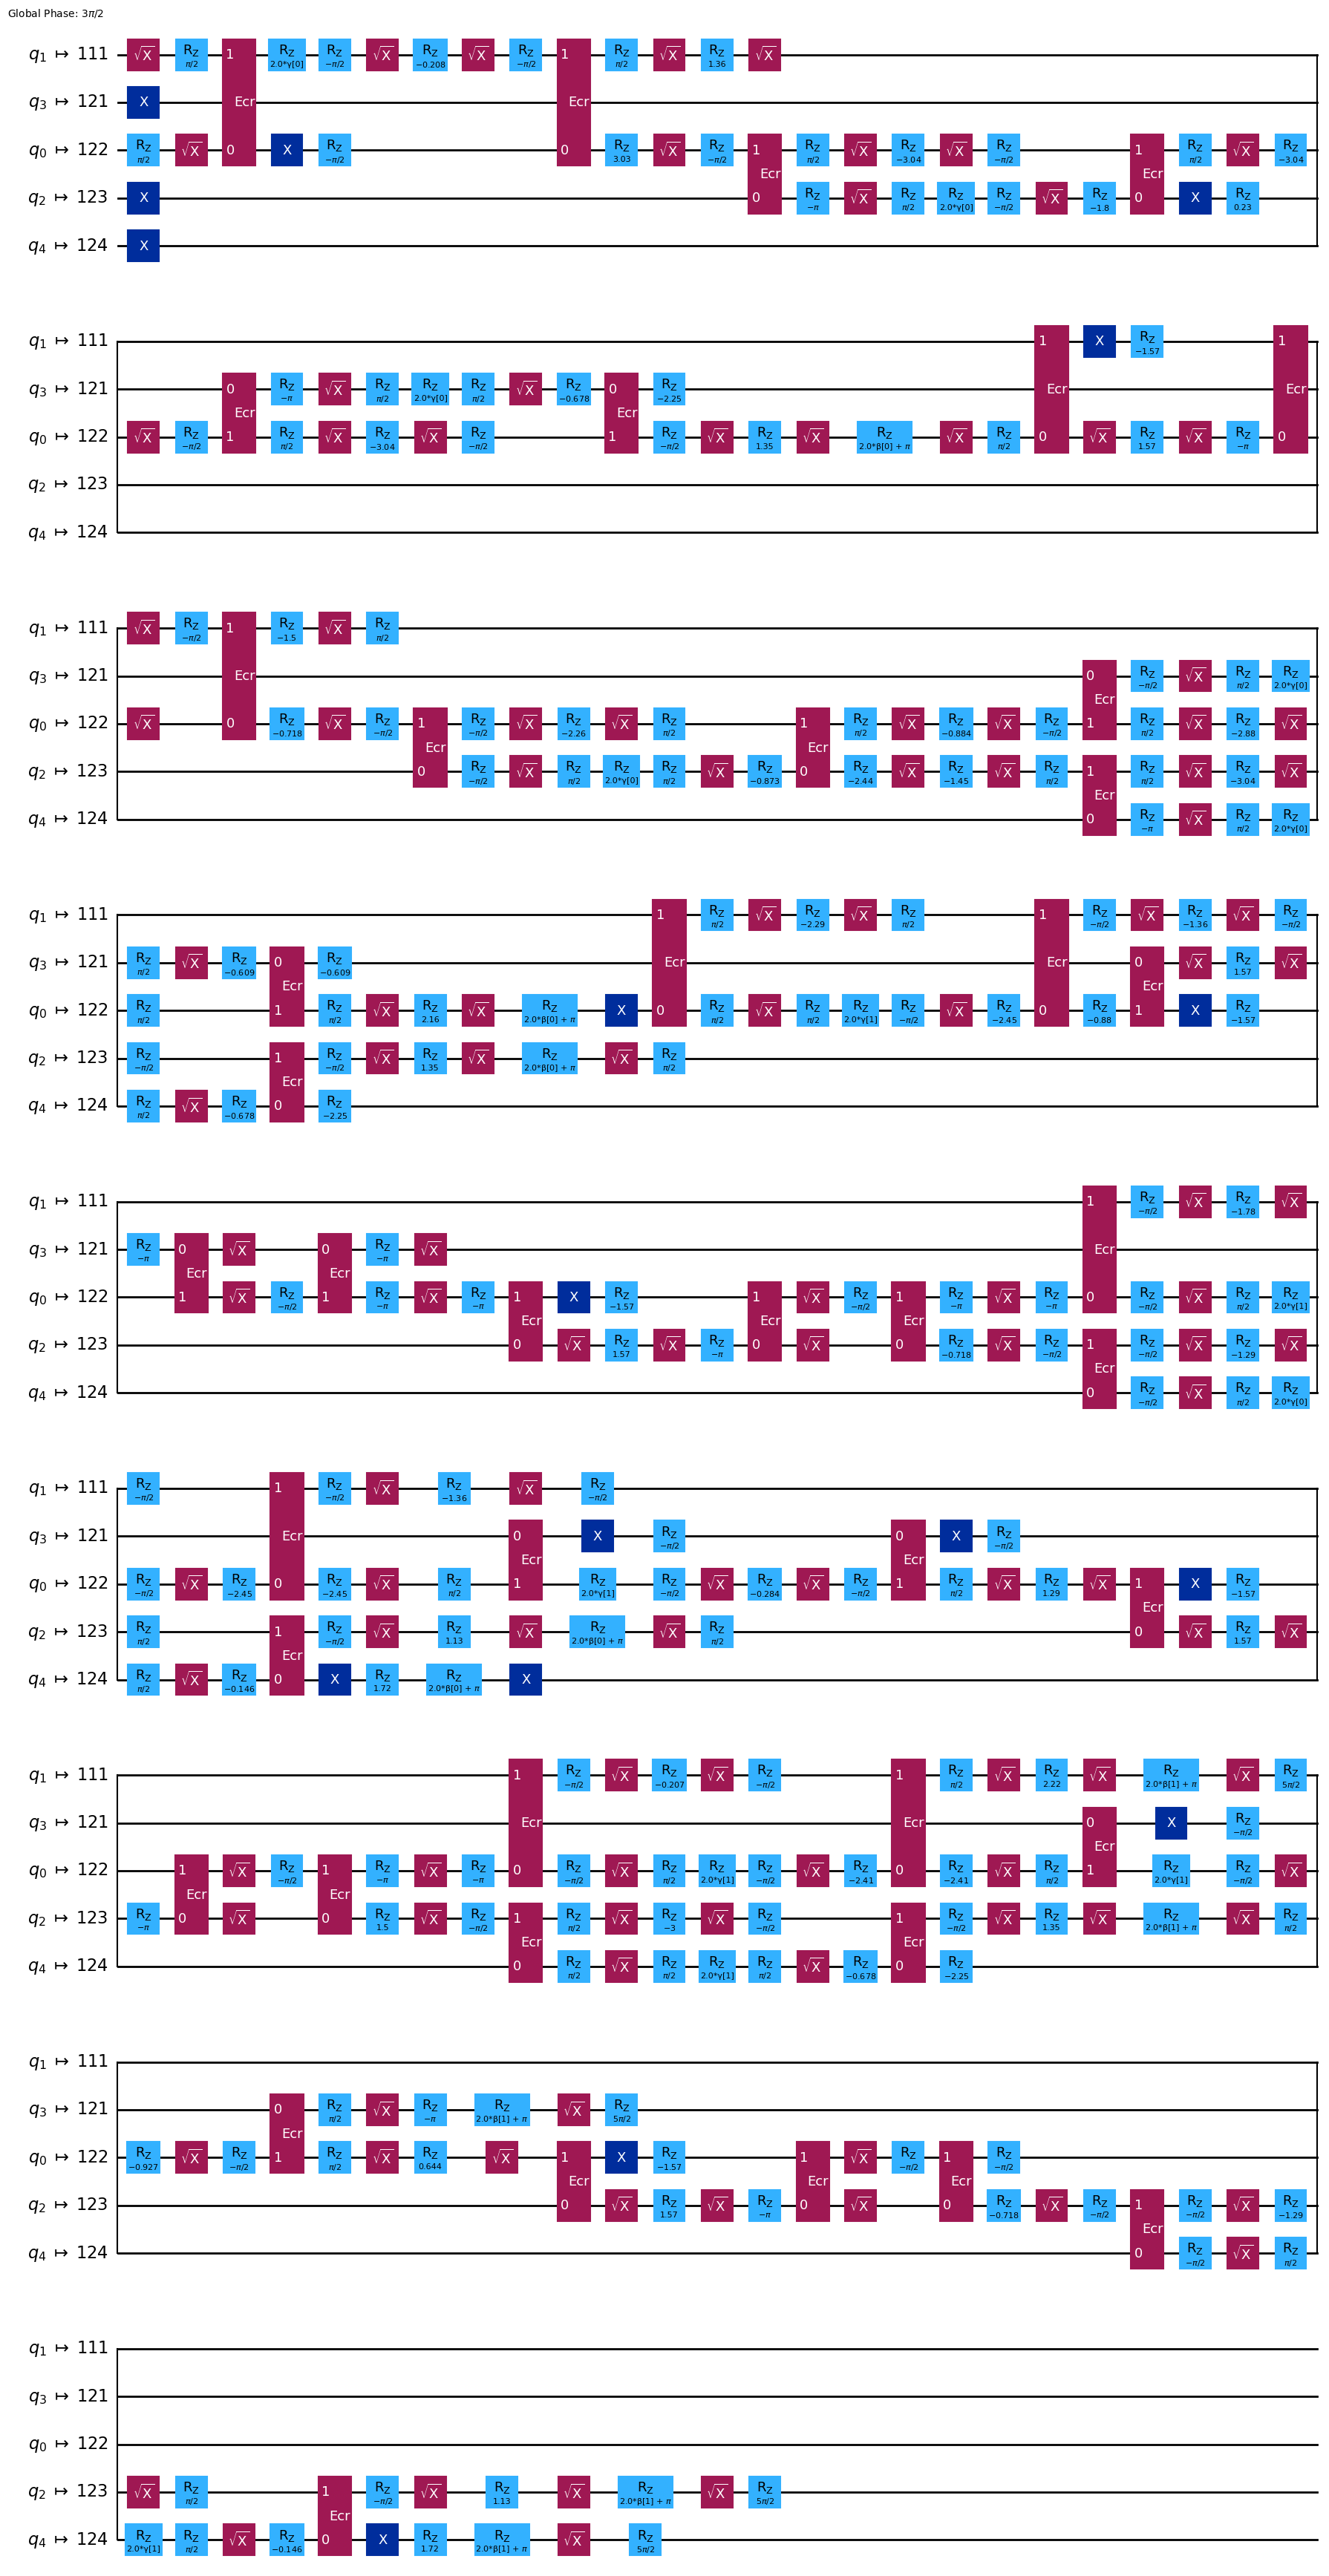

In [9]:
backend_answer = FakeSherbrooke()
optimization_level_answer = 3
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)
isa_circuit.draw('mpl', idle_wires=False,) 

In [10]:
hamiltonian_isa = hamiltonian.apply_layout(layout=isa_circuit.layout)

# Defining our cost function

In [11]:
def cost_function(params,ansatz,operator,estimator):
    
    pub =  (ansatz, [operator], [params])
    result = estimator.run(pubs=[pub]).result()
    expectation = result[0].data.evs[0]
    
    return expectation

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters) #Initial Parameters

# Classical Optimizer to minimize our cost function

In [12]:
backend = FakeSherbrooke()
with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_function,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator),
        method="cobyla",
        options={'maxiter': 150})

c:\Users\prade\miniconda3\envs\cwq\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [13]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.00830078125
       x: [ 3.492e+00  1.355e+00  5.936e+00  9.195e-01]
    nfev: 49
   maxcv: 0.0

In [14]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()


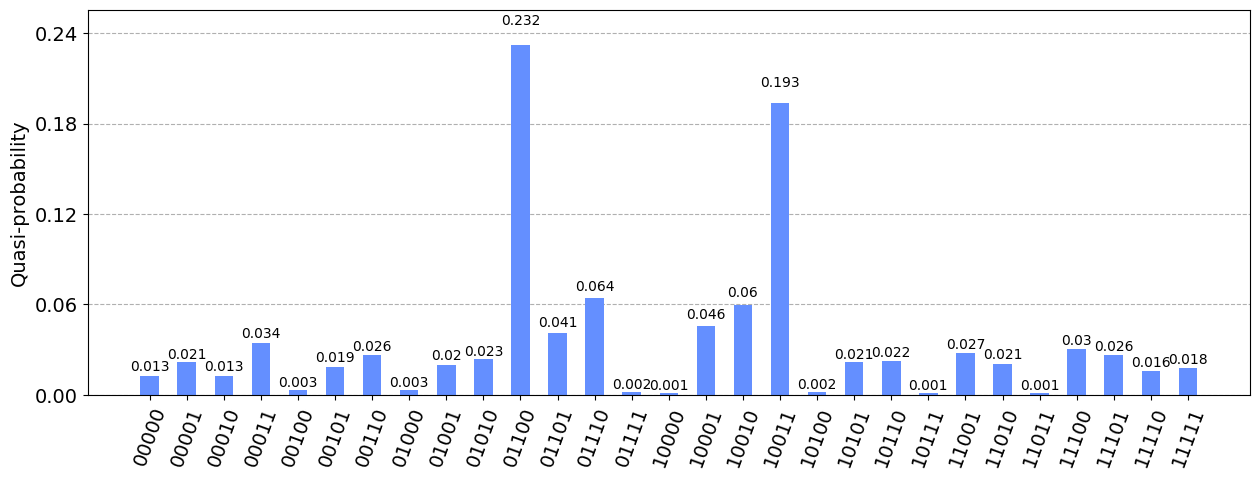

: 

In [15]:
sampler=StatevectorSampler()
result = sampler.run([qc]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))